In [4]:
import os

%load_ext autoreload
%autoreload 2
import pandas as pd
import matplotlib.pyplot as plt

from neuralmonkey.classes.population_mult import load_handsaved_wrapper, dfpa_match_chans_across_pa_each_bregion
from neuralmonkey.classes.population_mult import extract_single_pa

""""
Tutorail for moment by moment decoding --> i.e., for each time bin, find strength of representation of
each class of a variable (e.g., shape), as opposed to decoding average accuracy across trials.

Collects best preprocessing and decoder training methods, as I have determined so far.
"""

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'"\nTutorail for moment by moment decoding --> i.e., for each time bin, find strength of representation of\neach class of a variable (e.g., shape), as opposed to decoding average accuracy across trials.\n\nCollects best preprocessing and decoder training methods, as I have determined so far.\n'

# Load a dataset

To load and plot a dataset of neural activity across population, in a PopAnal class object.


In [5]:
if False:
    # Method 1 - load a single DFallPA
    DFallpa = load_handsaved_wrapper()


In [6]:
# Method 1 - load a single DFallPA
DFallpa = load_handsaved_wrapper(animal="Pancho", date=230623, version="trial", use_time=False)


In [7]:
if False:
    # Method 2 - Combine two dfallpa
    animal = "Diego"
    date = 231211
    COMBINE_AREAS = True

    DFallpa1 = load_handsaved_wrapper(animal=animal, date=date, version="trial", combine_areas=COMBINE_AREAS, use_time=False)
    DFallpa2 = load_handsaved_wrapper(animal=animal, date=date, version="stroke", combine_areas=COMBINE_AREAS, use_time=False)
    DFallpa = pd.concat([DFallpa1, DFallpa2]).reset_index(drop=True)


# Preprocessing

In [8]:
from neuralmonkey.classes.population_mult import load_handsaved_wrapper, dfpa_match_chans_across_pa_each_bregion
from neuralmonkey.classes.population_mult import extract_single_pa


##### Prune to chans that are common across pa for each bregion (intersection of chans)|

In [9]:
dfpa_match_chans_across_pa_each_bregion(DFallpa)

M1  ...  34
M1  ...  34
M1  ...  34
M1  -- n chans final:  34
PMv  ...  16
PMv  ...  16
PMv  ...  16
PMv  -- n chans final:  16
PMd  ...  55
PMd  ...  55
PMd  ...  55
PMd  -- n chans final:  55
dlPFC  ...  14
dlPFC  ...  14
dlPFC  ...  14
dlPFC  -- n chans final:  14
vlPFC  ...  29
vlPFC  ...  29
vlPFC  ...  29
vlPFC  -- n chans final:  29
FP  ...  10
FP  ...  10
FP  ...  10
FP  -- n chans final:  10
SMA  ...  49
SMA  ...  49
SMA  ...  49
SMA  -- n chans final:  49
preSMA  ...  32
preSMA  ...  32
preSMA  ...  32
preSMA  -- n chans final:  32


##### Removing noisy channels

In [10]:
from neuralmonkey.classes.population_mult import dfpa_concatbregion_preprocess_clean_bad_channels
dfpa_concatbregion_preprocess_clean_bad_channels(DFallpa, PLOT=False)

Keep, for  M1  ... 34 / 34
Keep, for  PMv  ... 15 / 16
Keep, for  PMd  ... 52 / 55
Keep, for  dlPFC  ... 12 / 14
Keep, for  vlPFC  ... 28 / 29
Keep, for  FP  ... 9 / 10
Keep, for  SMA  ... 44 / 49
Keep, for  preSMA  ... 27 / 32


##### Sqrt normalization

In [11]:
for pa in DFallpa["pa"]:
    pa.X = pa.X**0.5

### FR Normalization

##### Method 1 - each PA normalize independently

In [12]:
# from neuralmonkey.classes.population_mult import dfallpa_preprocess_fr_normalization
# # fr_normalization_method = "each_time_bin"
# fr_normalization_method = "across_time_bins"
# plot_savedir = "/tmp"
# dfallpa_preprocess_fr_normalization(DFallpa, fr_normalization_method, plot_savedir)

##### Method 2 - Concat events (for each bregion) and normalize all same way


In [13]:
# from neuralmonkey.classes.population_mult import dfpa_concat_normalize_fr_split_multbregion
# # fr_normalization_method = "each_time_bin"
# fr_normalization_method = "across_time_bins"
# dfpa_concat_normalize_fr_split_multbregion(DFallpa)


##### Method 3 - concat events (flexible version, only constrianed to have same n chans across PA) [works if have both trial and stroke!]

Running ..  M1
Running ..  PMv
Running ..  PMd
Running ..  dlPFC
Running ..  vlPFC
Running ..  FP
Running ..  SMA
Running ..  preSMA


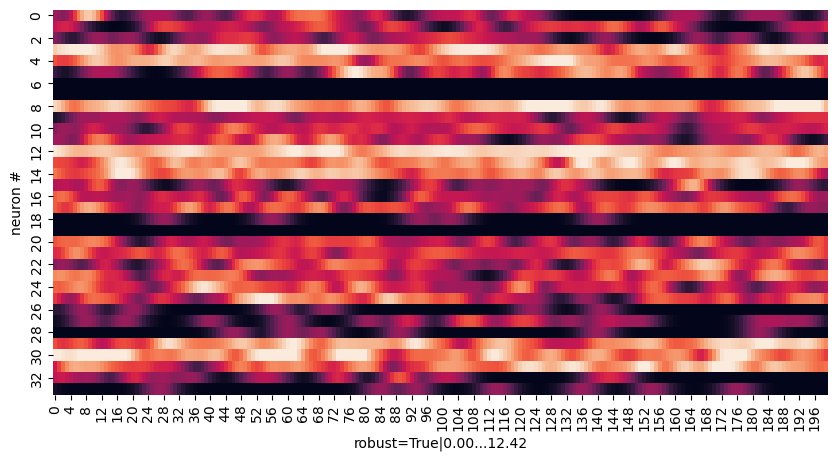

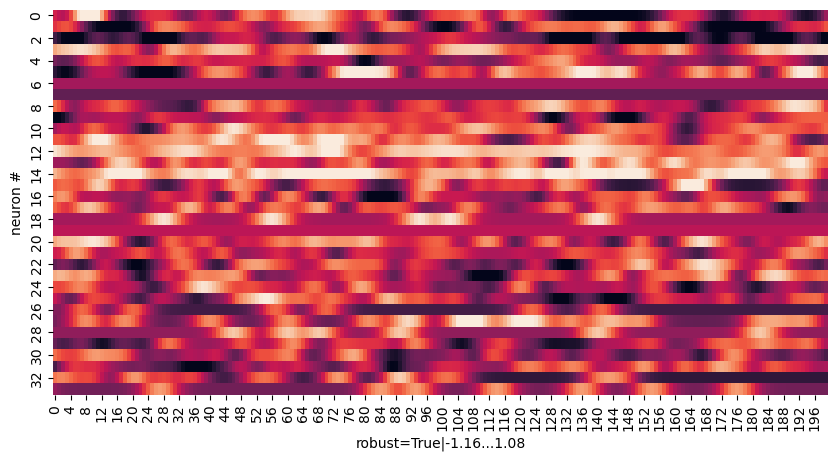

In [14]:
from neuralmonkey.classes.population_mult import dfpa_concat_normalize_fr_split_multbregion_flex
fr_mean_subtract_method = "across_time_bins"
# fr_mean_subtract_method = "each_time_bin"
PLOT=False

pa = DFallpa["pa"].values[0]
pa.plotNeurHeat(0)

dfpa_concat_normalize_fr_split_multbregion_flex(DFallpa, fr_mean_subtract_method, PLOT)

pa = DFallpa["pa"].values[0]
pa.plotNeurHeat(0)

# Extract relevant variables


In [15]:
# just adds "shapes_drawn" and "locs_drawn" to labels. Fine if it fails.

In [16]:
from neuralmonkey.scripts.analy_pig_decode_moment_syntaxTI import dfallpa_preprocess_condition
shape_var_suff = "shape"
loc_var_suff = "loc"
dfallpa_preprocess_condition(DFallpa, shape_var_suff, loc_var_suff)

# Pipeline to train and test decoder

In [17]:
from neuralmonkey.analyses.decode_moment import train_decoder_helper, pipeline_train_test_scalar_score, pipeline_train_test_scalar_score_mult_train_dataset, test_decoder_helper, train_decoder_helper_extract_train_dataset
from neuralmonkey.scripts.analy_pig_decode_moment_syntaxTI import get_dataset_params
import os

In [18]:
# Update this (or loop thru)
SAVEDIR = "/tmp"
bregion = "PMv"

In [32]:
# Pipeline to train and test

include_null_data = False
n_min_per_var = 5

# Train params
train_dataset = "sp_samp" # Which dataset to extract activity from, for training decoder.
var_train = "seqc_0_shape" # The trained variable

# Test params
test_dataset = "pig_samp" # Whicih dataset to test on. Follow the code to see other options. Or input your own below.
var_test = "seqc_0_shape"

# Subtrract baseline? from decoding score?
subtract_baseline=False
subtract_baseline_twind=(-0.45, -0.05)

# Helper to extract params
event_train, twind_train, filterdict_train, _, which_level_train = get_dataset_params(train_dataset)
event_test, _, filterdict_test, list_twind_test, which_level_test = get_dataset_params(test_dataset)

# Other general params
do_upsample_balance=True # Upsample data to fix imbalance?
PLOT = True
prune_labels_exist_in_train_and_test = True #
decoder_method_index = None # Use default
savedir = f"{SAVEDIR}/decoder_training-{train_dataset}-{test_dataset}-upsample={do_upsample_balance}/{bregion}"
os.makedirs(savedir, exist_ok=True)
print(savedir)

do_upsample_balance_fig_path_nosuff = f"{savedir}/upsample_pcs"

dfscores, Dc, PAtrain, PAtest = pipeline_train_test_scalar_score(DFallpa, bregion, 
                                     var_train, event_train, twind_train, filterdict_train,
                                     var_test, event_test, list_twind_test, filterdict_test,
                                     savedir, prune_labels_exist_in_train_and_test=prune_labels_exist_in_train_and_test, PLOT=PLOT,
                                     which_level_train=which_level_train, which_level_test=which_level_test, n_min_per_var=n_min_per_var,
                                     subtract_baseline=subtract_baseline, subtract_baseline_twind=subtract_baseline_twind,
                                     do_upsample_balance=do_upsample_balance)


/tmp/decoder_training-sp_samp-pig_samp-upsample=True/PMv
Keeping n trials / total:  246 / 246
Upsampling dataset...
line-8-4-0 [0 0 0 1]
line-8-4-0 [0 0 0 1]
Lcentered-4-3-0 [1 0 0 0]
Lcentered-4-3-0 [1 0 0 0]
V-2-2-0 [0 1 0 0]
V-2-2-0 [0 1 0 0]
arcdeep-4-1-0 [0 0 1 0]
Lcentered-4-3-0 [1 0 0 0]
V-2-2-0 [0 1 0 0]
line-8-4-0 [0 0 0 1]
Lcentered-4-3-0 [1 0 0 0]
line-8-4-0 [0 0 0 1]
line-8-4-0 [0 0 0 1]
arcdeep-4-1-0 [0 0 1 0]
Lcentered-4-3-0 [1 0 0 0]
arcdeep-4-1-0 [0 0 1 0]
Lcentered-4-3-0 [1 0 0 0]
line-8-4-0 [0 0 0 1]
line-8-4-0 [0 0 0 1]
V-2-2-0 [0 1 0 0]
Lcentered-4-3-0 [1 0 0 0]
line-8-4-0 [0 0 0 1]
Lcentered-4-3-0 [1 0 0 0]
arcdeep-4-1-0 [0 0 1 0]
arcdeep-4-1-0 [0 0 1 0]
arcdeep-4-1-0 [0 0 1 0]
arcdeep-4-1-0 [0 0 1 0]
arcdeep-4-1-0 [0 0 1 0]
line-8-4-0 [0 0 0 1]
arcdeep-4-1-0 [0 0 1 0]
line-8-4-0 [0 0 0 1]
arcdeep-4-1-0 [0 0 1 0]
V-2-2-0 [0 1 0 0]
arcdeep-4-1-0 [0 0 1 0]
Lcentered-4-3-0 [1 0 0 0]
arcdeep-4-1-0 [0 0 1 0]
arcdeep-4-1-0 [0 0 1 0]
Lcentered-4-3-0 [1 0 0 0]
arcdeep-4-1-

/home/lucas/miniconda3/envs/drag2_matlab/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/lucas/code/pythonlib/pythonlib/tools/snstools.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list_text,rotation=rotation, horizontalalignment="right")
/home/lucas/miniconda3/envs/drag2_matlab/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/lucas/miniconda3/envs/drag2_matlab/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/lucas/code/pythonlib/pythonlib/tools/snstools.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list_text,rotation=rotation, horizontalalignment="right")
/

In [33]:
print(f"Figures are saved at {savedir}")

Figures are saved at /tmp/decoder_training-sp_samp-pig_samp-upsample=True/PMv


### dfscores holds summaries of score for each trial x decoder class

In [34]:
# These are the trial indices, into PAtest.Xlabels["trials"]
dfscores["pa_idx"]

0         0
1         0
2         0
3         0
4         1
       ... 
3675    458
3676    459
3677    459
3678    459
3679    459
Name: pa_idx, Length: 3680, dtype: int64

In [35]:
# These are the decoder classes (as strings)
dfscores["decoder_class"]

0       Lcentered-4-3-0
1               V-2-2-0
2         arcdeep-4-1-0
3            line-8-4-0
4       Lcentered-4-3-0
             ...       
3675         line-8-4-0
3676    Lcentered-4-3-0
3677            V-2-2-0
3678      arcdeep-4-1-0
3679         line-8-4-0
Name: decoder_class, Length: 3680, dtype: object

In [36]:
# These are the decoder classes (as indices)
dfscores["decoder_idx"]


0       0
1       1
2       2
3       3
4       0
       ..
3675    3
3676    0
3677    1
3678    2
3679    3
Name: decoder_idx, Length: 3680, dtype: int64

In [37]:
# You can map between indices and class using this...
Dc.MapIdxToLabel

{0: 'Lcentered-4-3-0', 1: 'V-2-2-0', 2: 'arcdeep-4-1-0', 3: 'line-8-4-0'}

# Summary plots using dfscores

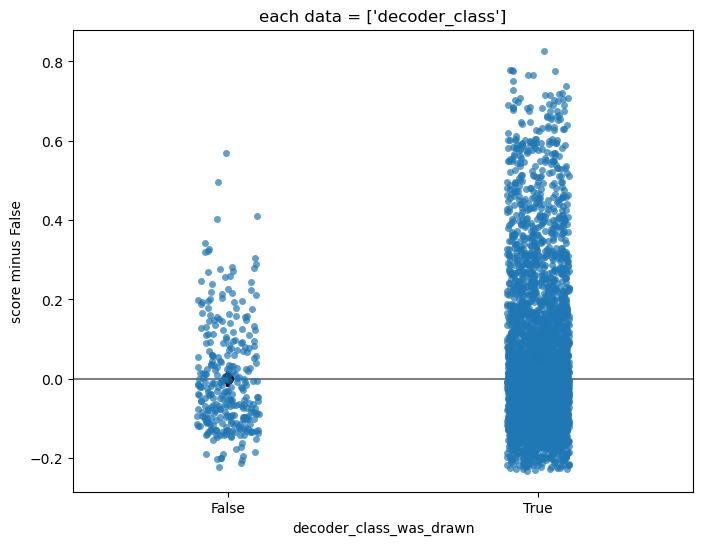

In [38]:
##### First, optionally append info to dfscores, related to trials.
dflab = PAtest.Xlabels["trials"]
list_decoder_class_idx_in_shapes_drawn = []
list_decoder_class_was_drawn = []
list_decoder_class_was_seen = []
list_decoder_class_was_first_drawn = []

for _i, row in dfscores.iterrows():

    decoder_class = row["decoder_class"]
    pa_idx = row["pa_idx"]
    trialcode = row["trialcode"]
    epoch = row["epoch"]

    shapes_drawn = dflab.iloc[pa_idx]["shapes_drawn"]
    FEAT_num_strokes_beh = dflab.iloc[pa_idx]["FEAT_num_strokes_beh"]
    # shapes_visible = dflab.iloc[pa_idx]["taskconfig_shp"]
    if decoder_class in shapes_drawn:
        decoder_class_idx_in_shapes_drawn = shapes_drawn.index(decoder_class)
    else:
        decoder_class_idx_in_shapes_drawn = -1
    
    assert FEAT_num_strokes_beh==len(shapes_drawn)
    assert decoder_class_idx_in_shapes_drawn<FEAT_num_strokes_beh
    
    list_decoder_class_idx_in_shapes_drawn.append(decoder_class_idx_in_shapes_drawn)
    list_decoder_class_was_drawn.append(decoder_class in shapes_drawn)
    # list_decoder_class_was_seen.append(decoder_class in shapes_visible)
    list_decoder_class_was_first_drawn.append(decoder_class == shapes_drawn[0])
    
dfscores["decoder_class_idx_in_shapes_drawn"] = list_decoder_class_idx_in_shapes_drawn
dfscores["decoder_class_was_drawn"] = list_decoder_class_was_drawn
# dfscores["decoder_class_was_seen"] = list_decoder_class_was_seen
dfscores["decoder_class_was_first_drawn"] = list_decoder_class_was_first_drawn

dfscores["FEAT_num_strokes_beh"] = [dflab.iloc[pa_idx]["FEAT_num_strokes_beh"] for pa_idx in dfscores["pa_idx"]]
dfscores["bregion"] = bregion


# Normalize decode by subtracting mean within each decoder class
from pythonlib.tools.pandastools import datamod_normalize_row_after_grouping_return_same_len_df
dfscores, _, _ = datamod_normalize_row_after_grouping_return_same_len_df(dfscores, "decoder_class_was_drawn", 
                                                                        ["decoder_class"], "score", False, True, True)




In [39]:
# You can make all summary plots starting from dfscores.
# for example...

In [40]:
dfscores

,score,decoder_class,decoder_class_good,pa_class,same_class,pa_class_is_in_decoder,decoder_class_is_in_pa,pa_idx,decoder_idx,trialcode,...,epoch,decoder_class_semantic,decoder_class_semantic_str,decoder_class_idx_in_shapes_drawn,decoder_class_was_drawn,decoder_class_was_first_drawn,FEAT_num_strokes_beh,bregion,score_mean,score_norm
0,0.070911,Lcentered-4-3-0,True,Lcentered-4-3-0,True,True,True,0,0,230623-1-100,...,230623,"(True, True, True)",111,0,True,True,4,PMv,0.235707,-0.164796
1,0.118952,V-2-2-0,True,Lcentered-4-3-0,False,True,True,0,1,230623-1-100,...,230623,"(False, True, True)",011,3,True,False,4,PMv,0.166781,-0.047829
2,0.163865,arcdeep-4-1-0,True,Lcentered-4-3-0,False,True,True,0,2,230623-1-100,...,230623,"(False, True, True)",011,2,True,False,4,PMv,0.220935,-0.057070
3,0.413247,line-8-4-0,True,Lcentered-4-3-0,False,True,True,0,3,230623-1-100,...,230623,"(False, True, True)",011,1,True,False,4,PMv,0.146133,0.267113
4,0.541013,Lcentered-4-3-0,True,line-8-4-0,False,True,True,1,0,230623-1-101,...,230623,"(False, True, True)",011,1,True,False,4,PMv,0.235707,0.305306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3675,0.168401,line-8-4-0,True,arcdeep-4-1-0,False,True,True,458,3,230623-1-98,...,230623,"(False, True, True)",011,3,True,False,4,PMv,0.146133,0.022267
3676,0.804587,Lcentered-4-3-0,True,Lcentered-4-3-0,True,True,True,459,0,230623-1-99,...,230623,"(True, True, True)",111,0,True,True,3,PMv,0.235707,0.568880
3677,0.206205,V-2-2-0,True,Lcentered-4-3-0,False,True,True,459,1,230623-1-99,...,230623,"(False, True, True)",011,2,True,False,3,PMv,0.166781,0.039423
3678,0.076888,arcdeep-4-1-0,True,Lcentered-4-3-0,False,True,True,459,2,230623-1-99,...,230623,"(False, True, True)",011,1,True,False,3,PMv,0.220935,-0.144046


/home/lucas/miniconda3/envs/drag2_matlab/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/lucas/miniconda3/envs/drag2_matlab/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


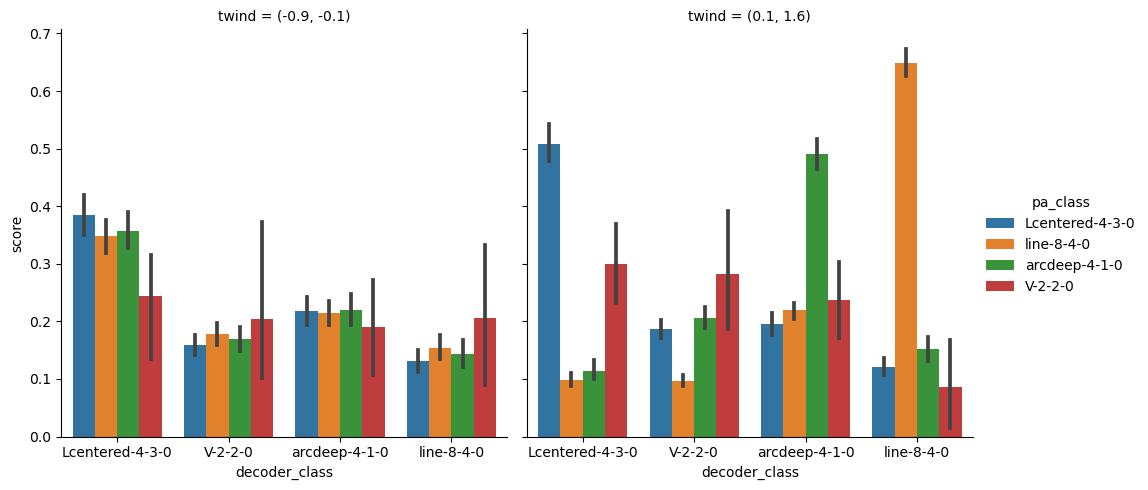

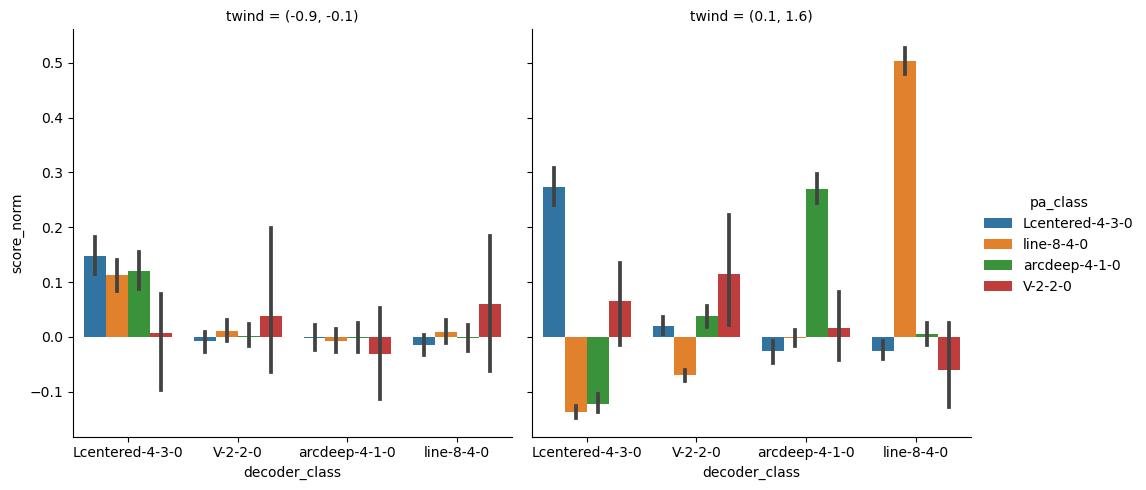

In [43]:
import seaborn as sns

sns.catplot(data=dfscores, x="decoder_class", y="score", hue="pa_class", kind="bar", col="twind")
sns.catplot(data=dfscores, x="decoder_class", y="score_norm", hue="pa_class", kind="bar", col="twind")

In [29]:
# See other plots in decode_moment.test_decoder_helper()

# Plot example single trials

For this trial 10, seqc_0_shape = Lcentered-4-3-0


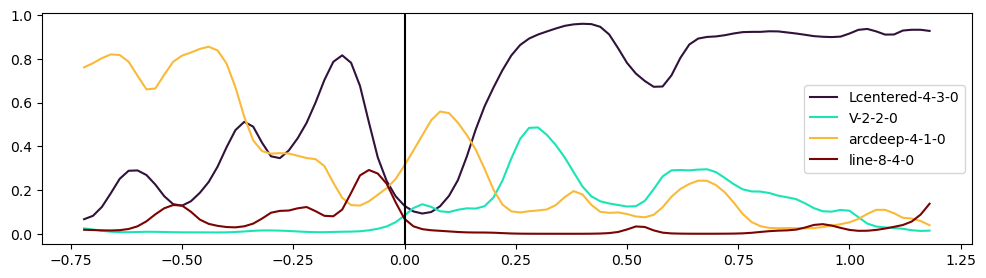

In [44]:
# Plot an example training trial

indtrial = 10
dflab = PAtrain.Xlabels['trials']
print(f"For this trial {indtrial}, {Dc.VarDecode} = {dflab.iloc[indtrial][Dc.VarDecode]}")
Dc.plot_single_trial(indtrial, PA=PAtrain);


For this trial 10, seqc_0_shape = line-8-4-0


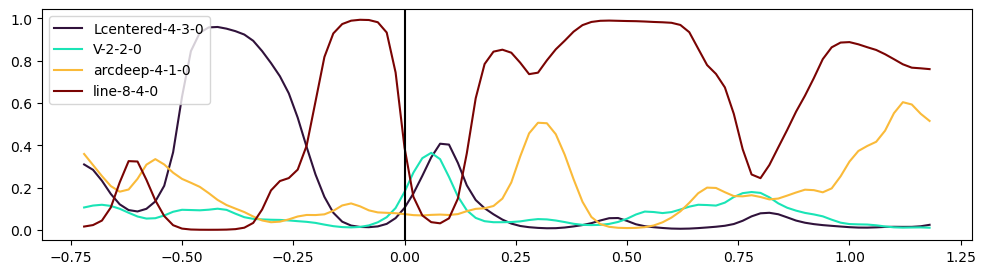

In [45]:
# Plot an example test trial

indtrial = 10
dflab = PAtest.Xlabels['trials']
print(f"For this trial {indtrial}, {Dc.VarDecode} = {dflab.iloc[indtrial][Dc.VarDecode]}")
Dc.plot_single_trial(indtrial, PA=PAtest);


# Plot summary of timeecourse (instad of scalar as above)

In [ ]:
# ie.., collect timecoures acorss all trials, and group (average) them and plot.

In [78]:
DEBUG = True

In [79]:
twind_test = (-0.6, 1.2) # time window to extract

In [80]:
### Get timecourses
# Get all test trials, just correct ones
dflab = PAtest.Xlabels["trials"]

# Take a subset
indtrials = list(range(len(dflab)))
if DEBUG: # take a few
    indtrials = list(range(50))
PAprobsOrig, probs_mat_all, times, labels = Dc.timeseries_score_wrapper(PAtest, twind_test, indtrials)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


SKIPPING!! this filtdict led to all data lost:
{'FEAT_num_strokes_task': [2], 'FEAT_num_strokes_beh': [2]}
SKIPPING!! this filtdict led to all data lost:
{'FEAT_num_strokes_task': [3], 'FEAT_num_strokes_beh': [3]}
PLOTTING... ()  (39, 5, 56)


/home/lucas/miniconda3/envs/drag2_matlab/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/lucas/miniconda3/envs/drag2_matlab/lib/python3.8/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


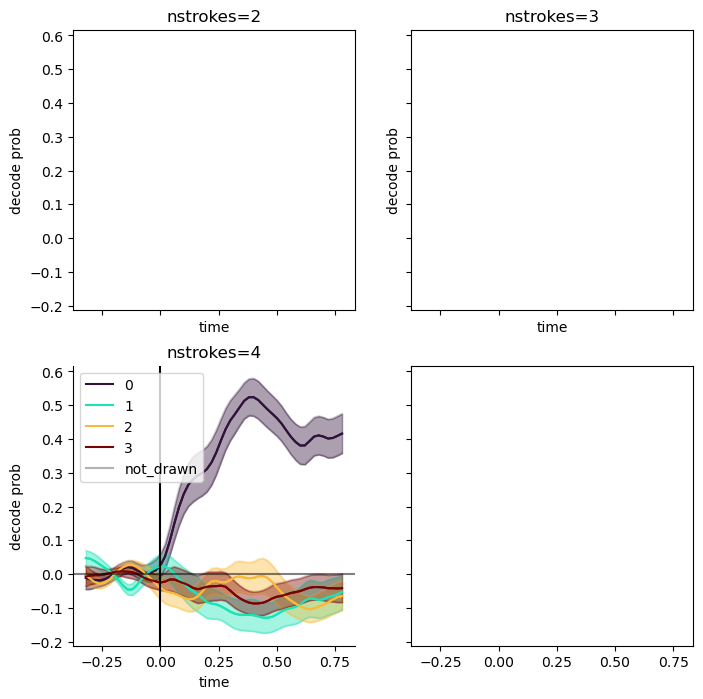

In [81]:

from pythonlib.tools.plottools import savefig

ylims = None
list_n_strokes = [2,3,4]
SIZE = 4

ncols = 2
nrows = 2
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*SIZE, nrows*SIZE), sharex=True, sharey=True)

### FILTER
ct = 0
for nstrokes in list_n_strokes:

    ax = axes.flatten()[ct]
    # ax.set_title(title)
    ax.set_xlabel("time")
    ax.set_ylabel("decode prob")
    ax.set_title(f"nstrokes={nstrokes}")

    ct+=1

    filtdict = {"FEAT_num_strokes_task":[nstrokes], "FEAT_num_strokes_beh":[nstrokes]}

    pathis = PAprobs.slice_by_labels_filtdict(filtdict)
    if len(pathis.Trials)==0:
        print("SKIPPING!! this filtdict led to all data lost:")
        print(filtdict)
        continue

    Dc.timeseries_plot_by_shape_drawn_order(pathis, ax, ylims=ylims)

# savefig(fig, f"{savedir}/timecourse_mean-subplot={savesuffix}-ylims={ylims}.pdf")
# plt.close("all")
